In [1]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
## Import the ecco_v4_py library into Python
## =========================================
from os.path import expanduser,join
import sys
#user_home_dir = expanduser('~')
#sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import numpy as np
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:
# grid parameter file name and path (after it has been downloaded)
grid_params_file_path = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
# open grid parameters file
grid = xr.open_dataset(grid_params_file_path)

<Figure size 1000x400 with 0 Axes>

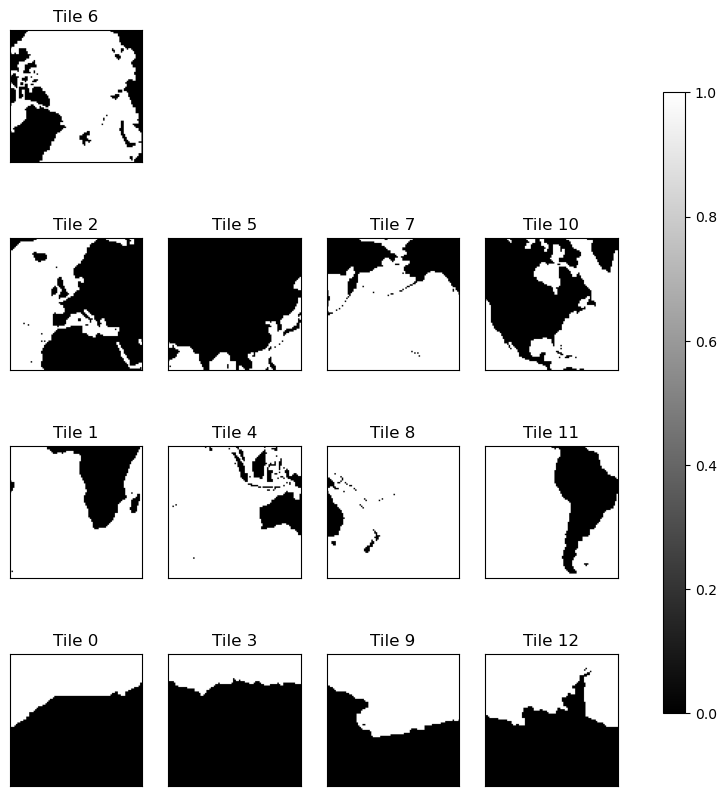

In [3]:
# surface mask
plt.figure(figsize=[10,4])
ecco.plot_tiles(grid.hFacC.isel(k=1), cmap='gray',layout='latlon',
                show_colorbar=True,rotate_to_latlon=True);

# Mask for 3D all depth in a cube (deep areas)

In [4]:
def plot_box_on_map(plot_ax, lonW, lonE, latN, latS,colorline,linewidth,exact,num_pts=20, delta=0.5):
        
    # Check if exact is equal to 'yes'
    if exact == 'yes':
        lonW = lonW
        lonE = lonE
        latN = latN
        latS = latS
    else:
        lonW = lonW-delta
        lonE = lonE+delta
        latN = latN+delta
        latS = latS-delta
    
    line_lons = []
    line_lats = []
    
    # west edge
    line_lons.append(np.ones(num_pts)*lonW)
    line_lats.append(np.linspace(latS,latN,num_pts))
    
    # north edge
    line_lons.append(np.linspace(lonW,lonE,num_pts))
    line_lats.append(np.ones(num_pts)*latN)
    
    # east edge
    line_lons.append(np.ones(num_pts)*lonE)
    
    line_lats.append(np.linspace(latS,latN,num_pts))
    # south edge

    line_lons.append(np.linspace(lonW,lonE,num_pts))
    line_lats.append(np.ones(num_pts)*latS)
    # plot 4 lines on map
    color=colorline
    for i in range(4):
        plot_ax.plot(line_lons[i], line_lats[i],
             color=colorline, linewidth=linewidth, marker='.', markersize=1,
             transform=crs.PlateCarree(), zorder=100)

In [5]:
# load the ecco grid into memory
grid.load();

global sum of area-weighted mask values is 0.9999999999999998


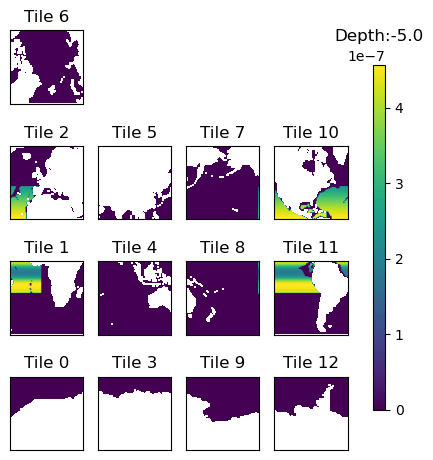

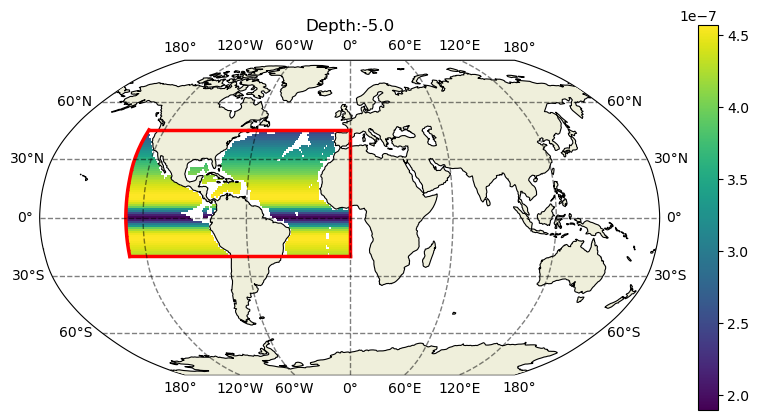

In [7]:
land_mask=grid.maskC.copy(deep=True)
land_mask_nan = land_mask.copy(deep=True)
land_mask_nan = land_mask_nan.where(land_mask_nan == True)

# define box boundaries
lonW = -130; lonE = 0; latN = 45; latS = -20

depth_mask = np.where(grid.Depth > 3000, 1, 0)
lat_mask = np.where(np.logical_and(grid.YC > latS, grid.YC < latN), 1, 0)
lon_mask = np.where(np.logical_and(grid.XC > lonW, grid.XC < lonE), 1, 0)
latlondepth_mask = land_mask*lat_mask *lon_mask*depth_mask

# calculate total volume
vol=grid.drF*grid.rA
vol_mask=latlondepth_mask*vol

# calculate the total area of wet cells in tile 11
total_vol_mask=vol_mask.sum(dim=['i','j','k','tile']).compute()

# the mask is defined by the vol(i,j)/total_vol_mask
# each grid cell is weighted by its fraction of the total volume
vol_mask_coef=vol_mask/total_vol_mask

# make a new DataArray object, use grid.XC as the template for coordiantes, etc.
global_3D_mask = grid.maskC.copy(deep=True)*0

# populate the values with the volume-weighted mask values calculated above
global_3D_mask.values = vol_mask_coef.values

# give some helpful name
global_3D_mask.name = 'custom_3D_mask'
global_3D_mask.attrs['long_name'] = 'custom area weighted 3D mask of wet cells'

outside_mask = np.where(global_3D_mask ==0, np.nan,1)
# verify the global sum of the mask is 1
print(f'global sum of area-weighted mask values is {global_3D_mask.sum().values}')


depth_index_k=0 # 0 to surface, 49 to bottom (this only to plot). 
z=grid.Z.isel(k=depth_index_k).values
z_str = str(z)

# plots
ecco.plot_tiles(global_3D_mask.isel(k=depth_index_k)*land_mask_nan.isel(k=depth_index_k), 
                layout='latlon', rotate_to_latlon=True, fig_size=5, show_colorbar=True);
plt.title('Depth:' + z_str)

plt.figure(figsize=[10,5])
X = ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, 
                                  global_3D_mask.isel(k=depth_index_k)*outside_mask[depth_index_k],
                                  dx=1,dy=1,show_grid_labels=True,show_colorbar=True);

plt.title('Depth:' + z_str)

plot_box_on_map(X[1], lonW, lonE, latN, latS,
                colorline='red',linewidth=2.5,exact='yes')

# Save mask in binary (Big Endian Byte Order) and netcdf

In [8]:
global_3D_mask_compact = ecco.llc_tiles_to_compact(global_3D_mask)


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float64


In [9]:
name_mask='global_3D_mask_cube_deep_areas'
# for binary 
from pathlib import Path
file_path_compact = Path(name_mask+'.bin')
with open(file_path_compact, "wb") as file:
    global_3D_mask_compact.astype('>f4').tofile(file)
# for netcdf
file_path_netcdf = Path(name_mask+'.nc')
with open(file_path_netcdf, "wb") as file:
    global_3D_mask.to_netcdf(file)

Data variables:
    custom_3D_mask  (k, tile, j, i) float64 ...


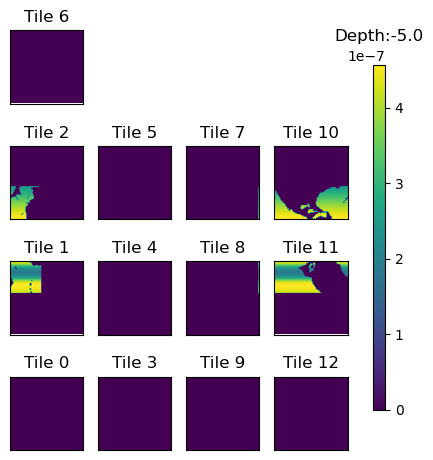

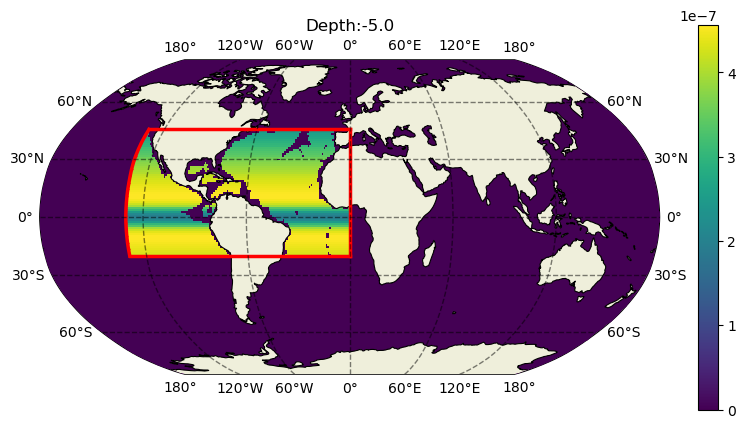

In [10]:
# read the mask in netcdf format
test_nc = xr.open_dataset(file_path_netcdf)
print(test_nc.data_vars)
ecco.plot_tiles(test_nc.custom_3D_mask.isel(k=depth_index_k),layout='latlon', 
                rotate_to_latlon=True, fig_size=5, 
                show_colorbar=True);
plt.title('Depth:' + z_str)

plt.figure(figsize=[10,5])
X=ecco.plot_proj_to_latlon_grid(test_nc.XC, test_nc.YC,
                                  test_nc.custom_3D_mask.isel(k=depth_index_k),dx=1,dy=1, 
                                  show_colorbar=True,show_grid_labels=True);
plt.title('Depth:' + z_str)
plot_box_on_map(X[1], lonW, lonE, latN, latS,
                colorline='red',linewidth=2.5,exact='yes')